In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.datasets.cifar10 import load_data

In [2]:
(train_x, train_y), (test_x, test_y) = load_data()
train_x = train_x.astype('float') / 127.5 - 1.
test_x  = test_x.astype('float')  / 127.5 - 1.
print(f'Train {train_x.shape} {train_y.shape}')
print(f'Test {test_x.shape} {test_y.shape}')

Train (50000, 32, 32, 3) (50000, 1)
Test (10000, 32, 32, 3) (10000, 1)


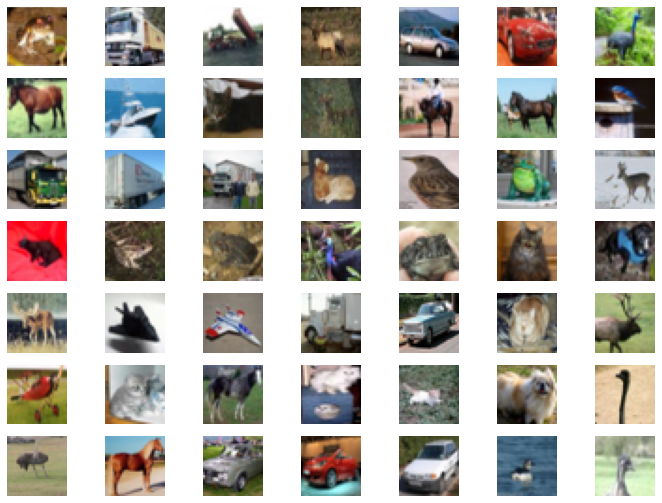

In [3]:
plt.figure(figsize=(12,9))
display_row = 7
for i in range(display_row**2):
    plt.subplot(display_row,display_row,i+1)
    plt.imshow(train_x[i]*0.5 + 0.5)
    plt.axis('off')
plt.show()

In [24]:
def generate_samples(n=80):
    # (N, Height, Width, Channel) -> (N, Channel, Height, Width)
    return np.transpose(train_x[np.random.randint(0,train_y.size, size=(n,))], (0,3,1,2))

def generate_samples_fake(n=80):
    # generate random pixels ranging from [-1,1] with shape (n,3,32,32)
    return np.random.random((n,3,32,32)) * 2. - 1. 
    
print(generate_samples(2).shape)

(2, 3, 32, 32)


In [65]:
discriminator = torch.nn.Sequential(
    torch.nn.Conv2d(3, 64, (3,3), stride=(2,2)),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(64, 64, (3,3), stride=(2,2)),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(64, 64, (3,3), stride=(2,2)),
    torch.nn.LeakyReLU(),
    torch.nn.Flatten(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(576,2),
    torch.nn.Softmax(dim=-1)
)
optimizer_dis = torch.optim.Adam(discriminator.parameters())

In [66]:
epochs = 50
batch_size = 80
accs = []
for epoch in tqdm(range(epochs)):
    # discriminator
    samples_real = generate_samples(batch_size // 2)
    samples_fake = generate_samples_fake(batch_size // 2)
    samples_real = torch.Tensor(samples_real)
    samples_fake = torch.Tensor(samples_fake)

    predicts_real = discriminator(samples_real)
    predicts_fake = discriminator(samples_fake)
    loss = - torch.mean(torch.log(predicts_real[:,1])) - torch.mean(torch.log(predicts_fake[:,0]))
    
    optimizer_dis.zero_grad()
    loss.backward()
    optimizer_dis.step()

    acc  = np.sum(np.argmax(predicts_real.detach().numpy(), axis=-1))
    acc += batch_size // 2 - np.sum(np.argmax(predicts_fake.detach().numpy(), axis=-1))
    accs.append(acc / batch_size)

100%|██████████| 50/50 [00:01<00:00, 31.27it/s]


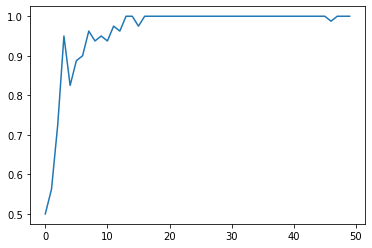

In [67]:
plt.plot(accs)

If the fake images are generated at random, $20$ epochs (within a second) is sufficient for the discriminator to reach an $100\%$ accuracy. Now we set up both a discriminator and a generator.

In [252]:
latent_dim = 100

discriminator = torch.nn.Sequential(
    torch.nn.Conv2d(3, 64, (3,3), padding=1),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Conv2d(64, 128, (3,3), stride=(2,2), padding=1),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Conv2d(128, 128, (3,3), stride=(2,2), padding=1),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Conv2d(128, 128, (3,3), stride=(2,2), padding=1),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Flatten(),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(2048, 2),
    torch.nn.Softmax(dim=-1)
)

generator = torch.nn.Sequential(
    torch.nn.Linear(100, 4096),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Unflatten(1, (256, 4, 4)),
    # 4x4 -> 8x8
    torch.nn.ConvTranspose2d(256, 128, (4,4), stride=2, padding=1),
    torch.nn.LeakyReLU(0.2),
    # 8x8 -> 16x16
    torch.nn.ConvTranspose2d(128, 64, (4,4), stride=2, padding=1),
    torch.nn.LeakyReLU(0.2),
    # 16x16 -> 32x32
    torch.nn.ConvTranspose2d(64, 64, (4,4), stride=2, padding=1),
    torch.nn.LeakyReLU(0.2),
    # to 3 channels
    torch.nn.ConvTranspose2d(64, 3, (3,3), padding=1),
    # map to [-1,1]
    torch.nn.Tanh()
)

optimizer_dis = torch.optim.Adam(discriminator.parameters(),lr=2e-4,betas=(0.5,0.999))
optimizer_gen = torch.optim.Adam(generator.parameters(),lr=2e-4,betas=(0.5,0.999))
losses_dis = []
losses_gen = []
epoch = 0

In [91]:
# check that the generator outputs correct size
latent_seeds = torch.Tensor(np.random.randn(20, latent_dim))
print(generator(latent_seeds).shape)

torch.Size([20, 3, 32, 32])


In [370]:
epochs = 10000
batch_size = 128

for epoch in tqdm(range(1+len(losses_gen), 1+len(losses_gen)+epochs)):
    # discriminator
    samples_real = torch.Tensor(generate_samples(batch_size // 2))

    latent_seeds = torch.Tensor(np.random.randn(batch_size // 2, latent_dim))
    samples_fake = generator(latent_seeds)

    predicts_real = discriminator(samples_real)
    predicts_fake = discriminator(samples_fake)
    loss  = -torch.mean(torch.log(predicts_real[:,1])) 
    loss -=  torch.mean(torch.log(predicts_fake[:,0]))
    losses_dis.append(loss.item())

    optimizer_dis.zero_grad()
    loss.backward()
    optimizer_dis.step()

    # generator
    latent_seeds = torch.Tensor(np.random.randn(batch_size // 2, latent_dim))
    samples_fake = generator(latent_seeds)

    predicts_fake = discriminator(samples_fake)
    loss  = -torch.mean(torch.log(predicts_fake[:,1]))
    losses_gen.append(loss.item())

    optimizer_gen.zero_grad()
    loss.backward()
    optimizer_gen.step()

    if epoch % 1000 == 0: # save a version
        torch.save(generator.state_dict()    , f'DCGAN Cifar Models\\Generator {epoch}.pth')
        torch.save(discriminator.state_dict(), f'DCGAN Cifar Models\\Discriminator {epoch}.pth')
        np.savetxt(f'DCGAN Cifar Models\\loss.txt', np.array([losses_gen, losses_dis]))

100%|██████████| 10000/10000 [3:36:54<00:00,  1.30s/it] 


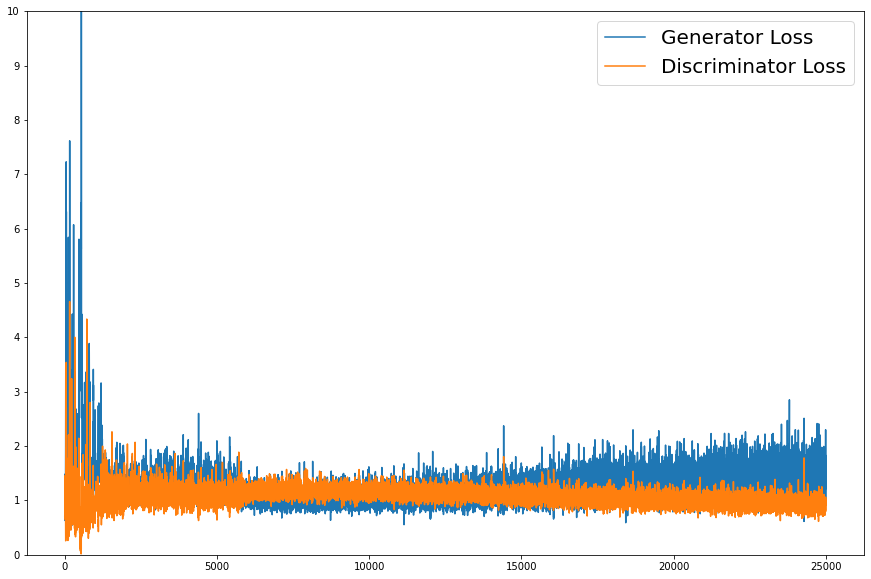

In [398]:
plt.figure(figsize=(15,10))
plt.plot(losses_gen)
plt.plot(losses_dis)
plt.legend(['Generator Loss','Discriminator Loss'], fontsize=20)
plt.ylim(0,10)
plt.yticks(range(0,11,1))
plt.show()

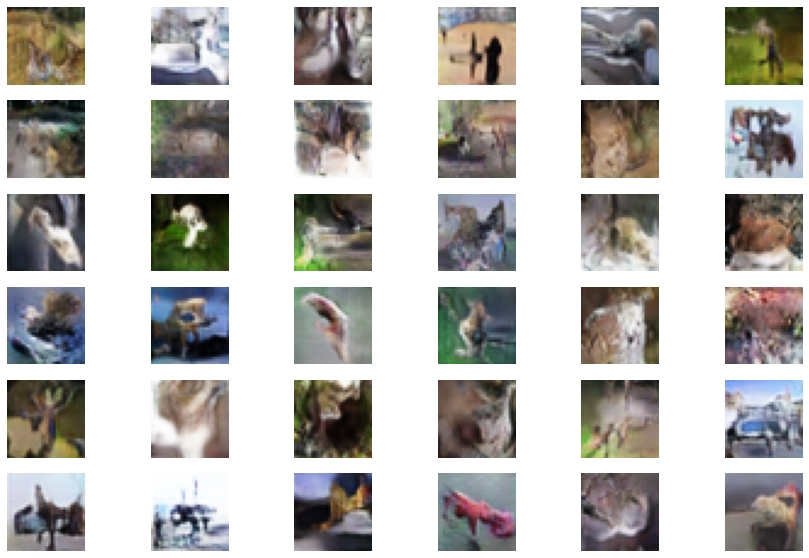

In [391]:
# these are the results after 25000 epochs
display_row = 6
latent_seeds = torch.Tensor(np.random.randn(display_row**2, latent_dim))
samples_fake = np.transpose(generator(latent_seeds).detach().numpy(), (0,2,3,1)) * 0.5 + 0.5
plt.figure(figsize=(15,10))
for i in range(display_row**2):
    plt.subplot(display_row,display_row,i+1)
    plt.axis('off')
    plt.imshow(samples_fake[i])
plt.show()

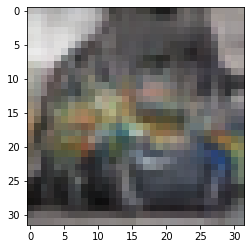

In [412]:
# take a look of the image generated by a vector of 0.75
# perhaps a dog ??
latent_seeds = torch.Tensor( np.full((1, latent_dim), 0.75) )
samples_fake = np.transpose( generator(latent_seeds).detach().numpy(), (0,2,3,1))[0] * 0.5 + 0.5
plt.imshow(samples_fake)
plt.show()

In [410]:
def validate(generator, discriminator, batch_size):
    samples_real  = torch.Tensor( generate_samples(batch_size) )
    predicts_real = discriminator(samples_real).detach().numpy()
    acc_real      = np.sum(np.argmax(predicts_real, axis=-1)) / batch_size

    latent_seeds  = torch.Tensor( np.random.randn(batch_size, latent_dim) )
    samples_fake  = generator(latent_seeds)
    predicts_fake = discriminator(samples_fake).detach().numpy()
    acc_fake      = 1. - np.sum(np.argmax(predicts_fake, axis=-1)) / batch_size

    return acc_real, acc_fake

acc_real, acc_fake = validate(generator,discriminator,500)
print(f'Accuracy on generated images = {acc_fake*100}%')
print(f'Accuracy on realworld images = {acc_real*100}%')

Accuracy on generated images = 90.8%
Accuracy on realworld images = 66.2%


It seems that the generator is not strong enough (the discriminator is fooled by some of the real world images rather than generated ones).

Epochs =  [1000, 4000, 7000, 10000, 13000, 16000, 19000, 22000, 25000]


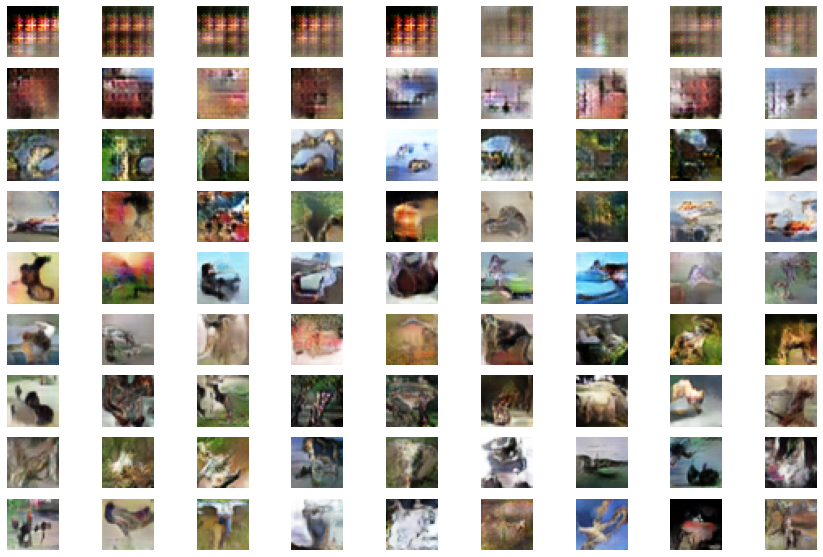

In [413]:
# check the performance of the generator
display_row = 9
display_epochs = list(range(1000,26000,3000))
print('Epochs = ', display_epochs)
plt.figure(figsize=(15,10))
for i, loadepoch in enumerate(display_epochs):
    generator.load_state_dict(torch.load(f'DCGAN Cifar Models\\Generator {loadepoch}.pth'))
    #discriminator.load_state_dict(torch.load(f'DCGAN Cifar Models\\Discriminator {loadepoch}.pth'))
    latent_seeds = torch.Tensor( np.random.randn(display_row,latent_dim) )
    samples_fake = np.transpose(generator(latent_seeds).detach().numpy(), (0,2,3,1)) * 0.5 + 0.5

    for j in range(display_row):
        plt.subplot(len(display_epochs), display_row, i*display_row+j+1)
        plt.axis('off')
        plt.imshow(samples_fake[j])
plt.show()

Conclusions: In our experiment, the generator fails to draw anything that resembles a photograph in the first $1000$ epochs. With $4000$ epochs it does seem to have learnt something. 

After $10000$ epochs or more, the generator is able to generate some plausible images. Although all of them are blurred and perhaps far from anything in the real world, they do seem like photographs at first glance -- if not enlarged or carefully observed.